In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

from utils import OptimOneCycleLR

%matplotlib inline

# ResNet Model

## Residual Block

In [2]:
class ResBlock(nn.Module):
    def __init__(self, channels_in, channels_out, stride=1):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels_out)
        self.conv2 = nn.Conv2d(channels_out, channels_out, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels_out)
        
        self.shortcut = None
        if channels_in != channels_out:
            self.shortcut = nn.Sequential(
                nn.Conv2d(channels_in, channels_out, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channels_out),
            )
    
    def forward(self, x):
        shct = x
        if self.shortcut is not None: shct = self.shortcut(shct)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += shct
        x = F.relu(x)
        return x

## ResNet Class

In [3]:
class ResNetShallow(nn.Module):
    def __init__(self, first_channels, num_blocks, num_classes):
        super(ResNetShallow, self).__init__()
        self.channels = first_channels
        
        self.conv1 = nn.Conv2d(3, self.channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.channels)
        self.layer1 = self._make_layer(num_blocks[0], False)
        self.layer2 = self._make_layer(num_blocks[1], True)
        self.layer3 = self._make_layer(num_blocks[2], True)
        self.layer4 = self._make_layer(num_blocks[3], True)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(self.channels, num_classes)
        
    def _make_layer(self, num_blocks, downsample=True):
        layers = []
        for i in range(num_blocks):
            if i==0 and downsample:
                layers.append(ResBlock(self.channels, self.channels*2, 2))
                self.channels *= 2
            else:
                layers.append(ResBlock(self.channels, self.channels, 1))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

In [4]:
def ResNet18(first_channels, num_classes):
    return ResNetShallow(first_channels, [2, 2, 2, 2], num_classes)

def ResNet34(first_channels, num_classes):
    return ResNetShallow(first_channels, [3, 4, 6, 3], num_classes)

# Dataset

In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomAffine(degrees=10., scale=(0.9,1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5070754 , 0.48655024, 0.44091907), (0.26733398, 0.25643876, 0.2761503))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5070754 , 0.48655024, 0.44091907), (0.26733398, 0.25643876, 0.2761503))
])

In [6]:
trainset = torchvision.datasets.CIFAR100(
    root='../data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(
    root='../data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
num_train = trainset.__len__()
num_test = testset.__len__()
bs_train = 1024
bs_test = 2048

In [8]:
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=bs_train, shuffle=True, num_workers=4, pin_memory=True)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=bs_test, shuffle=True, num_workers=4, pin_memory=True)

# Training

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
net = ResNet18(64, 100)
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

In [23]:
epochs=50
criterion = nn.CrossEntropyLoss()

# SGD
# optimizer = optim.SGD(net.parameters(), lr=0.08, momentum=0.9, weight_decay=1e-4, nesterov=True)
# scheduler = OptimOneCycleLR(optimizer, 0.1, 1., 0.001,
#                             epochs, len(trainloader), 0.2, 0.4)

# AdamW
optimizer = torch.optim.AdamW(net.parameters(), lr=0.001, betas=[0.9, 0.999], eps=1e-08, weight_decay=1e-4, amsgrad=False)
scheduler = OptimOneCycleLR(optimizer, 1e-3, 1e-2, 1e-5,
                            epochs, len(trainloader), 0.1, 0.5, 0.2, 0.1)

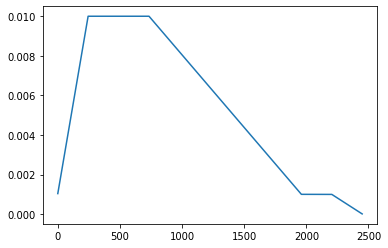

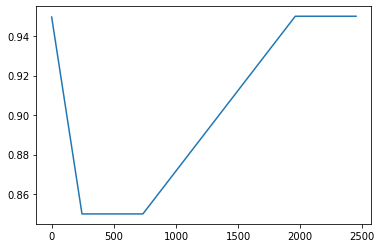

In [24]:
lr = []
mtm = []
for i in range(epochs*len(trainloader)):
    a, b = scheduler.step()
    lr.append(a)
    mtm.append(b)
    
plt.figure(1)
plt.plot(lr)
plt.figure(2)
plt.plot(mtm)

In [ ]:
# x, y = next(iter(trainloader))
# x, y = x.to(device), y.to(device)

# epochs = 100
# optimizer = torch.optim.AdamW(net.parameters(), lr=0.001, betas=[0.9, 0.999], eps=1e-08, weight_decay=1e-4, amsgrad=False)
# scheduler = OptimOneCycleLR(optimizer, 1e-3, 1e-2, 1e-5,
#                             epochs, 1, 0.2, 0.4)

# print(f"Begin Training for {epochs} epoch")

# for epoch in range(1, epochs + 1):
#     train_loss = 0
#     train_correct = 0
#     train_total = 0
    
#     net.train()
        
#     pred = net(x)
#     loss = criterion(pred, y)

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     scheduler.step()

#     preds = torch.argmax(pred, dim=1)
#     train_loss += loss.item()
#     train_correct += (preds == y).sum().item()
#     train_total += y.size(0)

#     print(f'Epoch: {epoch} || train_loss: {train_loss / ((num_train - 1) // bs_train + 1):.5f} || train_acc : {train_correct / train_total:.5f}')

In [ ]:
print(f"Begin Training for {epochs} epoch")
test_best_acc = 1000.
for epoch in range(1, epochs + 1):
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    net.train()
    for i, (x, y) in enumerate(trainloader):
        x, y = x.to(device), y.to(device)
        
        pred = net(x)
        loss = criterion(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        preds = torch.argmax(pred, dim=1)
        train_loss += loss.item()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)
        
    test_loss = 0
    test_correct = 0
    test_total = 0
    
    net.eval()
    for x, y in testloader:
        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            pred = net(x)
            loss = criterion(pred, y)

            preds = torch.argmax(pred, dim=1)
            test_loss += loss.item()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    print(f'Epoch: {epoch} || train_loss: {train_loss / ((num_train - 1) // bs_train + 1):.5f} || train_acc : {train_correct / train_total:.5f} || test_loss: {test_loss / ((num_test - 1) // bs_test + 1):.5f} || test_acc : {test_correct / test_total:.5f} ')
    
    if test_best_acc > test_correct / test_total:
        torch.save(net.state_dict(), 'models/CIFAR100/ResNet18/model.pt')
        
torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss / ((num_train - 1) // bs_train + 1),
            }, "models/CIFAR100/ResNet18/last_checkpoints.pt")